<a href="https://colab.research.google.com/github/Udendra103/Healthcare/blob/master/uden_disaster_tweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

nlp_getting_started_path = kagglehub.competition_download('nlp-getting-started')
udensingh_glove1000_path = kagglehub.dataset_download('udensingh/glove1000')

print('Data source import complete.')


GitHub repository URL:


Twitter has become an important communication channel in times of emergency. But, it’s not always clear whether a person’s words are actually announcing a disaster as it is a social media language so it is not easy to identify them, as a result it is given as a Kaggle problem in which we have to build a machine learning model that predicts which Tweets are about real disasters and which one are not.


Here we have access to a dataset of 10,000 tweets that were hand classified and three files have been provided train.csv, test.csv and sample_submission.csv where each sample in the train and test set has the following information: The text of a tweet, A keyword from that tweet (although this may be blank!) The location the tweet was sent from (may also be blank. Here we have to predict whether a given tweet is about a real disaster or not. If so, predict 1. If not, predict a 0 hence it is a binary classification problem here we will use f1 score which will give priority to accuracy and recall.

PROBLEM STATEMENT

Given a Tweet predict whether it tells about a real disaster or not.

GETTING TO KNOW THE DATA

Files

    train.csv — the training set

    test.csv — the test set

    sample_submission.csv — a sample submission file in the correct format

Columns

    id — a unique identifier for each tweet
    text — the text of the tweet
    location — the location the tweet was sent from (may be blank)
    keyword — a particular keyword from the tweet (may be blank)

What You’re Predicting: Your main goal is to figure out if a tweet is about a real disaster or not. In the training set, the ‘target’ column tells you this:

    1: The tweet talks about a real disaster
    
    0: The tweet isn't about a disaster

MODEL ARCHITECTURES:

To accomplish the task, I will:

1. Data Preprocessing: Use the preprocessed text data and convert it into a numerical format suitable for training neural   networks (e.g., tokenization and padding for RNN-based models).

2. Build RNN Models:
   Start with a basic RNN (GRU).

   Experiment with LSTM and Bidirectional RNNs.

   Incorporate additional layers like attention or dropout for improved performance.
   
3. Hyperparameter Tuning:

   Test different architectures (number of layers, units, dropout rates).

   Vary training parameters such as batch size, learning rate, and optimizers.

   Use cross-validation or a validation set to evaluate the models.

4. Results Analysis: Display training/validation loss curves, metrics, and confusion matrices where applicable.



In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/glove1000/glove.6B.100d.txt


In [ ]:
# Importing Necessary Modules
import pandas as pd
import nltk
import re
from sklearn.model_selection import train_test_split
from transformers import ElectraTokenizer
import spacy
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
sns.set(style="whitegrid")

from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, GRU, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Loading all files
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
sample_data = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

In [ ]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train_data.shape, test_data.shape

((7613, 5), (3263, 4))

In [ ]:
for col in train_data.columns:
    print("{} has {} unique instances".format(col, len(train_data[col].unique())))

id has 7613 unique instances
keyword has 222 unique instances
location has 3342 unique instances
text has 7503 unique instances
target has 2 unique instances


In [ ]:
null_counts = train_data.isnull().sum()
print(null_counts)

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


## EXPLOLATORY DATA ANALYSIS (EDA)-— Inspect, Visualize and Clean the Data

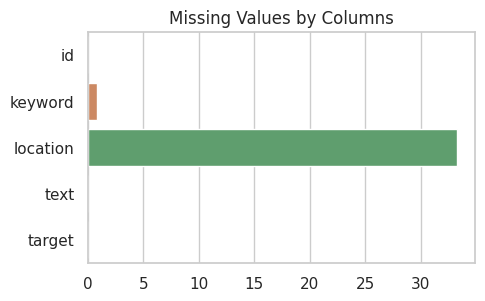

In [ ]:
# Get the percentage of missing values
output = train_data.isnull().sum() * 100  / len(train_data)
# type(output) : Pandas Series

# plot them
plt.figure(figsize=[5,3])
sns.barplot(y=list(output.index), x=list(output))
plt.title('Missing Values by Columns')
plt.show()

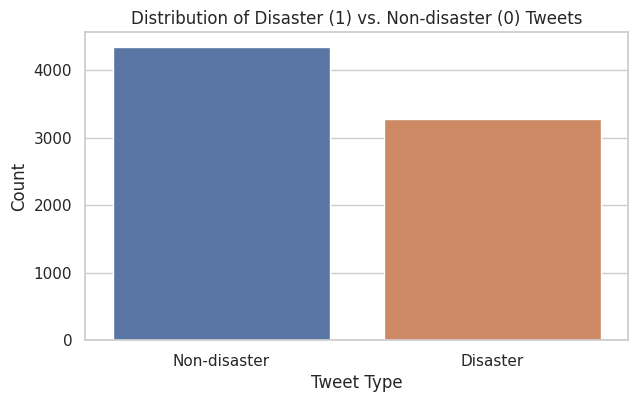

In [ ]:
plt.figure(figsize=(7, 4))
sns.countplot(x='target', data=train_data)
plt.title('Distribution of Disaster (1) vs. Non-disaster (0) Tweets')
plt.xlabel('Tweet Type')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-disaster', 'Disaster'])
plt.show()

Text(0.5, 0.98, 'Characters in tweets')

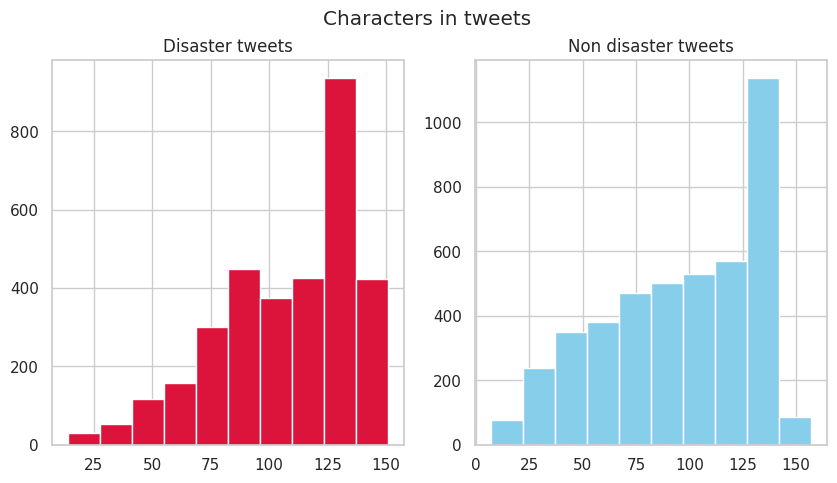

In [ ]:
#Number of characters in tweets
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

tweet_len = train_data[train_data['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='crimson')
ax1.set_title('Disaster tweets')

tweet_len = train_data[train_data['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='skyblue')
ax2.set_title('Non disaster tweets')
fig.suptitle('Characters in tweets')

Text(0.5, 0.98, 'Average word length in each tweet')

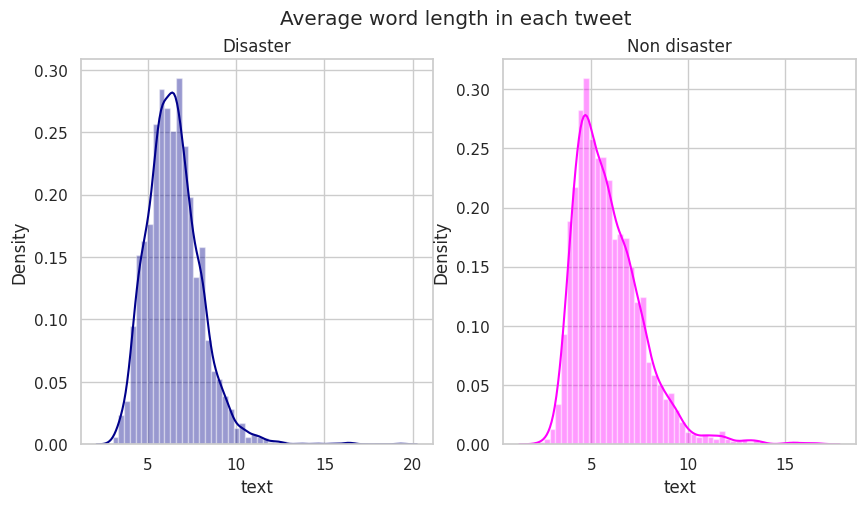

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word = train_data[train_data['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='darkblue')
ax1.set_title('Disaster')
word = train_data[train_data['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='magenta')
ax2.set_title('Non disaster')
fig.suptitle('Average word length in each tweet')

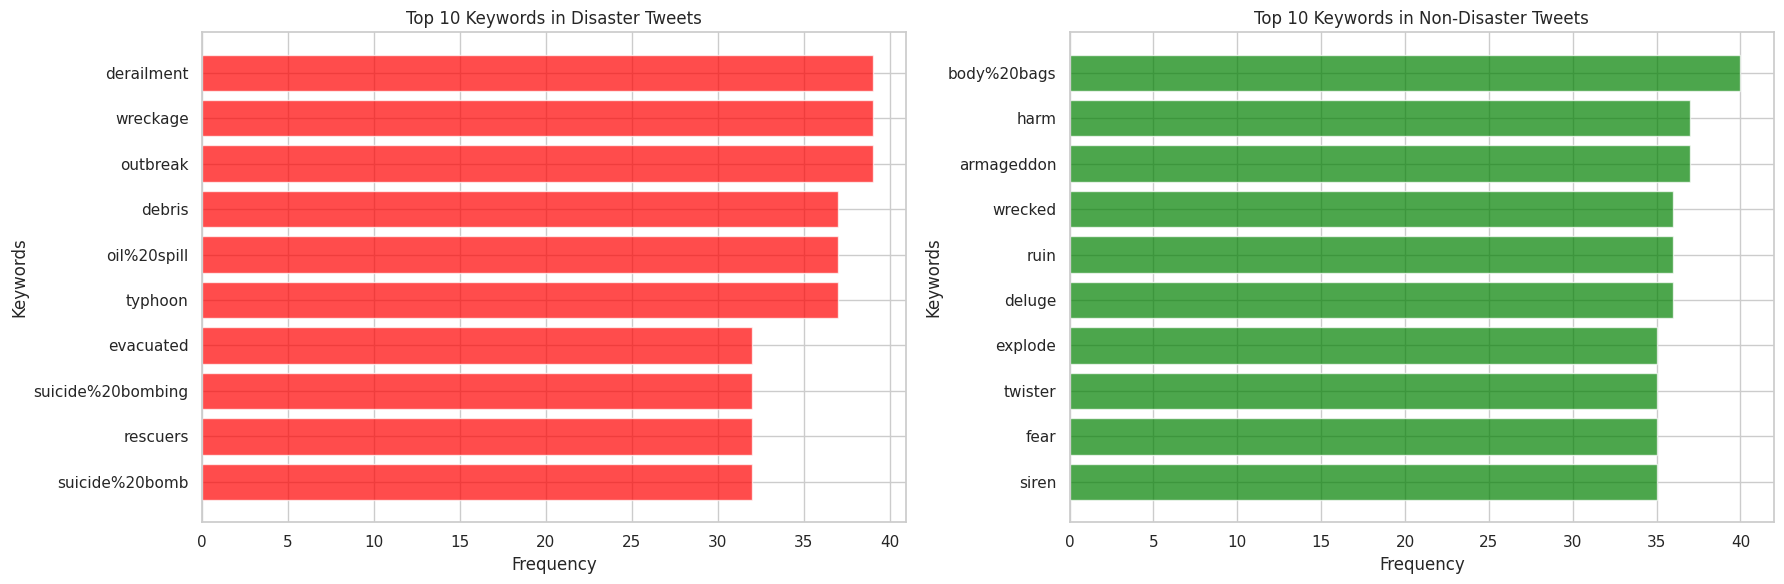

In [ ]:
# Calculate top 10 keywords for disaster and non-disaster tweets
keyword_disaster = train_data[train_data['target'] == 1]['keyword'].value_counts().head(10)
keyword_non_disaster = train_data[train_data['target'] == 0]['keyword'].value_counts().head(10)

# Create a figure with two subplots
plt.figure(figsize=(18, 6))

# Plot for Disaster Keywords
plt.subplot(1, 2, 1)
plt.barh(keyword_disaster.index, keyword_disaster.values, color="red", alpha=0.7)
plt.title("Top 10 Keywords in Disaster Tweets")
plt.xlabel("Frequency")
plt.ylabel("Keywords")
plt.gca().invert_yaxis()  # Invert y-axis for better readability

# Plot for Non-Disaster Keywords
plt.subplot(1, 2, 2)
plt.barh(keyword_non_disaster.index, keyword_non_disaster.values, color="green", alpha=0.7)
plt.title("Top 10 Keywords in Non-Disaster Tweets")
plt.xlabel("Frequency")
plt.ylabel("Keywords")
plt.gca().invert_yaxis()  # Invert y-axis for consistency

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## Cleaning Data

As with any real-world data, our dataset was messy. Tweets often have hashtags, mentions, links, and more. Cleaning this data was crucial. I created a function to strip away these unnecessary parts, leaving us with clean text for analysis.

In [ ]:
# Data Cleaning/Preprocessing
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Initialize the Porter Stemmer
ps = PorterStemmer()

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and numbers
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)  # remove single characters
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)  # remove single characters from the start
    text = re.sub(r'\s+', ' ', text, flags=re.I)  # replace multiple spaces with single space

    # Tokenization
    words = word_tokenize(text)

    # Removing stopwords and stemming
    filtered_words = [ps.stem(word) for word in words if word not in stop_words]

    return ' '.join(filtered_words)

# Apply preprocessing to the text column of the train dataset
train_data['processed_text'] = train_data['text'].apply(preprocess_text)
train_data[['text', 'processed_text']].head()

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,processed_text
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquak may allah forgiv us
1,Forest fire near La Ronge Sask. Canada,forest fire near la rong sask canada
2,All residents asked to 'shelter in place' are ...,resid ask shelter place notifi offic evacu she...
3,"13,000 people receive #wildfires evacuation or...",13 000 peopl receiv wildfir evacu order califo...
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo rubi alaska smoke wildfir pour ...


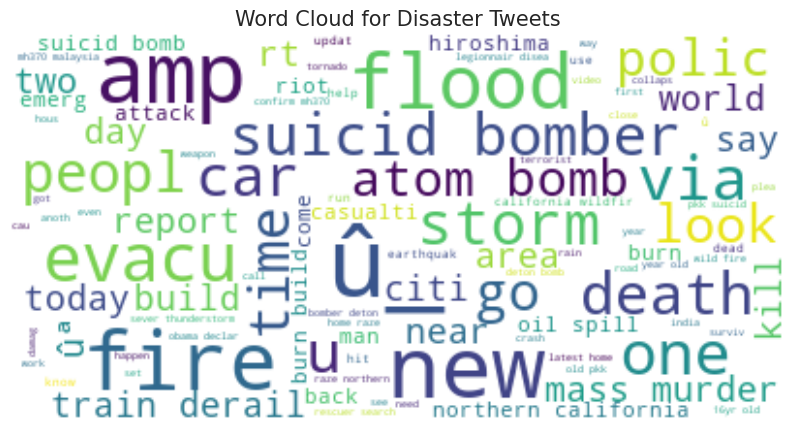

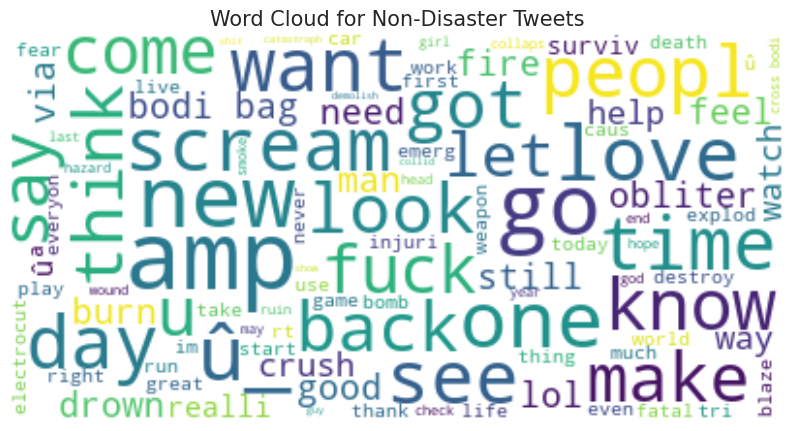

In [ ]:
from wordcloud import WordCloud

# Function to generate a word cloud
def generate_word_cloud(data, title):
    text = " ".join(review for review in data)
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=15)
    plt.axis("off")
    plt.show()

# Generate word clouds for disaster and non-disaster tweets
disaster_tweets = train_data[train_data['target'] == 1]['processed_text']
non_disaster_tweets = train_data[train_data['target'] == 0]['processed_text']

generate_word_cloud(disaster_tweets, "Word Cloud for Disaster Tweets")
generate_word_cloud(non_disaster_tweets, "Word Cloud for Non-Disaster Tweets")

Tokenize Text:

I Tokenize and pad the sequences using TensorFlow's Tokenizer and pad_sequences and then Split the data for model training and evaluation.

In [ ]:
# Tokenization and padding train
max_vocab_size = 5000  # Limit the vocabulary size
max_sequence_length = 50  # Fixed input size for neural networks

tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data['processed_text'])
sequences = tokenizer.texts_to_sequences(train_data['processed_text'])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Splitting the train data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, train_data['target'], test_size=0.2, random_state=42)

# Display the shape of the training and test sets, and vocabulary size
(X_train.shape, X_test.shape, len(tokenizer.word_index))

((6090, 50), (1523, 50), 13992)

## Model Building

With the text data tokenized and padded, and the training/test split completed, the next step is to build, train, and evaluate the RNN model. I'll start with a simple GRU-based architecture, train it on the dataset, and evaluate its performance.

In [ ]:
# GRU MODEL

# Model parameters
embedding_dim = 64  # Size of the embedding vector
gru_units = 128  # Number of GRU units
dropout_rate = 0.2  # Dropout rate for regularization
learning_rate = 0.001  # Learning rate for the Adam optimizer
max_vocab_size = 5000  # Vocabulary size
max_sequence_length = 50  # Input sequence length

# GRU model architecture
gru_model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    GRU(units=gru_units, return_sequences=False),  # GRU layer
    Dropout(rate=dropout_rate),  # Dropout for regularization
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
gru_model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Display the model summary
gru_model.summary()

# Training parameters
batch_size = 32
epochs = 10
history = gru_model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1)

# Evaluate the GRU model
loss, accuracy = gru_model.evaluate(X_test, y_test, verbose=1)
loss, accuracy

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.5511 - loss: 0.6882 - val_accuracy: 0.5739 - val_loss: 0.6825
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.5668 - loss: 0.6858 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.5591 - loss: 0.6870 - val_accuracy: 0.5739 - val_loss: 0.6827
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.5640 - loss: 0.6858 - val_accuracy: 0.5739 - val_loss: 0.6832
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.5721 - loss: 0.6839 - val_accuracy: 0.5739 - val_loss: 0.6840
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.5633 - loss: 0.6857 - val_accuracy: 0.5739 - val_loss: 0.6831
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.5722 - loss: 0.6839 - val_accuracy: 0.5739 - val_loss: 0.6825
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.5625 - loss: 0.6858 - 

(0.6823809146881104, 0.5738673806190491)

The validation accuracy remains constant at ~57.39%, while the validation loss fluctuates but doesn't show much improvement.
Lets try basic LSTM Model.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - accuracy: 0.5633 - loss: 0.6872 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.5776 - loss: 0.6824 - val_accuracy: 0.5739 - val_loss: 0.6823
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.5675 - loss: 0.6847 - val_accuracy: 0.5739 - val_loss: 0.6824
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.5633 - loss: 0.6863 - val_accuracy: 0.5739 - val_loss: 0.6823
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.5689 - loss: 0.6839 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.5744 - loss: 0.6824 - val_accuracy: 0.5739 - val_loss: 0.6827
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.5740 - loss: 0.6829 - val_accuracy: 0.5739 - val_loss: 0.6834
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.5618 - loss: 0.6859 - 

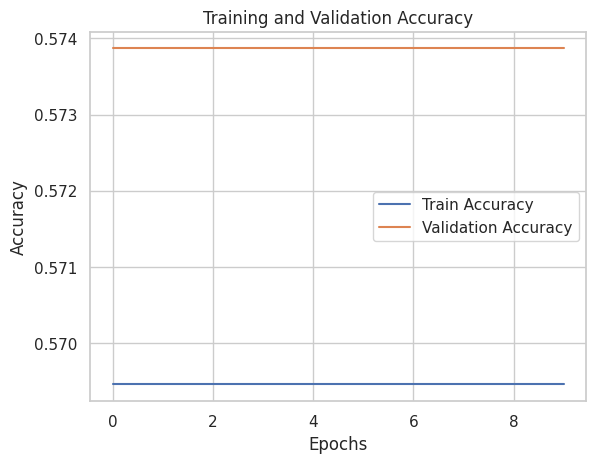

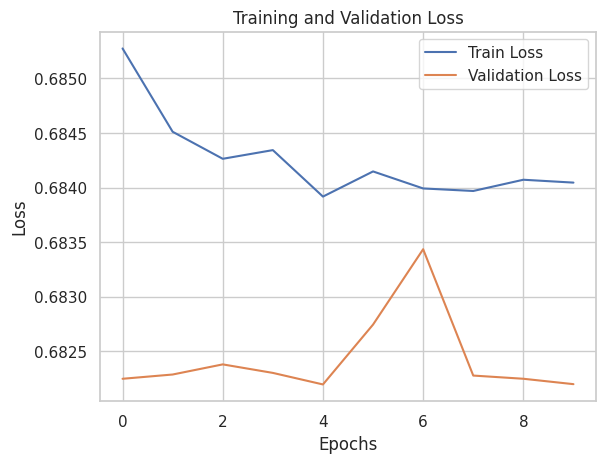

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5694 - loss: 0.6835
Test Loss: 0.682197093963623, Test Accuracy: 0.5738673806190491


In [ ]:
# Model parameters
embedding_dim = 64
lstm_units = 128
dropout_rate = 0.2
learning_rate = 0.001

# Basic LSTM model
model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    LSTM(units=lstm_units, return_sequences=False),
    Dropout(rate=dropout_rate),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# Train the model
batch_size = 32
epochs = 10

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

It seems the training and validation accuracy remains consistently low (around 0.57), while the training and validation loss fluctuates slightly without significant improvement. This indicates that the current model is likely underfitting the data.

Let’s enhance the model with a Bidirectional LSTM and incorporate dropout layers for regularization.
I will also add Dropout Layers after the LSTM layer to prevent overfitting.

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 49s 235ms/step - accuracy: 0.6528 - loss: 0.6154 - val_accuracy: 0.7774 - val_loss: 0.4770
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 45s 234ms/step - accuracy: 0.8411 - loss: 0.4910 - val_accuracy: 0.7925 - val_loss: 0.4662
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 45s 237ms/step - accuracy: 0.8951 - loss: 0.2678 - val_accuracy: 0.7938 - val_loss: 0.5053
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 44s 231ms/step - accuracy: 0.9180 - loss: 0.2079 - val_accuracy: 0.7735 - val_loss: 0.5624
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 45s 235ms/step - accuracy: 0.9379 - loss: 0.1812 - val_accuracy: 0.7643 - val_loss: 0.6869
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 44s 232ms/step - accuracy: 0.9470 - loss: 0.1481 - val_accuracy: 0.7728 - val_loss: 0.8085
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 82s 235ms/step - accuracy: 0.9604 - loss: 0.1172 - val_accuracy: 0.7663 - val_loss: 0.8326
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 82s 233ms/step - accuracy: 0.9729 - loss: 0

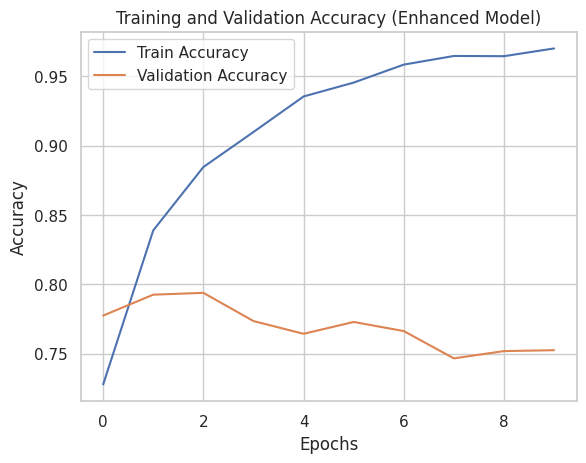

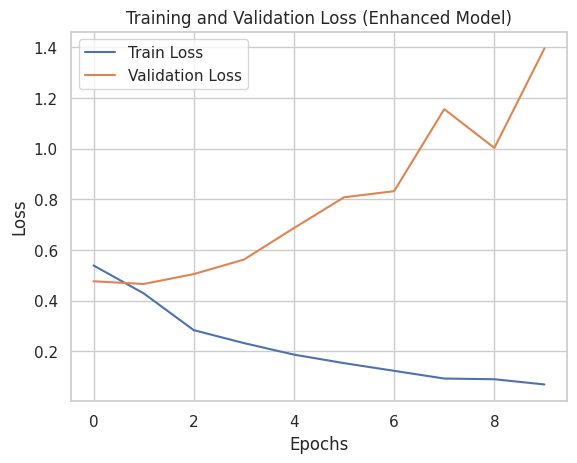

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.7363 - loss: 1.4520
Test Loss: 1.3959345817565918, Test Accuracy: 0.7524622678756714


In [ ]:
# Data preparation
max_vocab_size = 5000  # Limit the vocabulary size
max_sequence_length = 50  # Fixed input size for neural networks

# Model parameters
embedding_dim = 64
lstm_units = 256
dropout_rate = 0.3
learning_rate = 0.001

# Build the enhanced Bidirectional LSTM model
model2 = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    Bidirectional(LSTM(units=lstm_units, return_sequences=False)),  # Bidirectional LSTM
    Dropout(rate=dropout_rate),  # Dropout for regularization
    Dense(128, activation='relu'),  # Additional Dense Layer
    Dropout(rate=dropout_rate),  # Dropout for the Dense layer
    Dense(1, activation='sigmoid')  # Binary classification output
])

model2.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2.summary()

# Train the enhanced model
batch_size = 32
epochs = 10

history = model2.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (Enhanced Model)')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Enhanced Model)')
plt.legend()
plt.show()

# Evaluate the enhanced model on the test set
test_loss, test_accuracy = model2.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Training Accuracy and Loss:

The training accuracy increases significantly and approaches 1.0.
The training loss decreases steadily, indicating that the model is fitting the training data well.

Validation Accuracy and Loss:

The validation accuracy improves initially but plateaus around 0.75.
Validation loss increases after a few epochs, indicating potential overfitting.

Let’s implement Early Stopping and Increased Regularization to improve the generalization and prevent overfitting.
I will also increase dropout rates in the LSTM and dense layers.

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 51s 240ms/step - accuracy: 0.6115 - loss: 1.4580 - val_accuracy: 0.7735 - val_loss: 0.5288
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 45s 235ms/step - accuracy: 0.8346 - loss: 0.4466 - val_accuracy: 0.8142 - val_loss: 0.4712
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 46s 244ms/step - accuracy: 0.8717 - loss: 0.3603 - val_accuracy: 0.7938 - val_loss: 0.4830
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 45s 234ms/step - accuracy: 0.8975 - loss: 0.3163 - val_accuracy: 0.7846 - val_loss: 0.5277
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 45s 233ms/step - accuracy: 0.8976 - loss: 0.3253 - val_accuracy: 0.7951 - val_loss: 0.5501
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


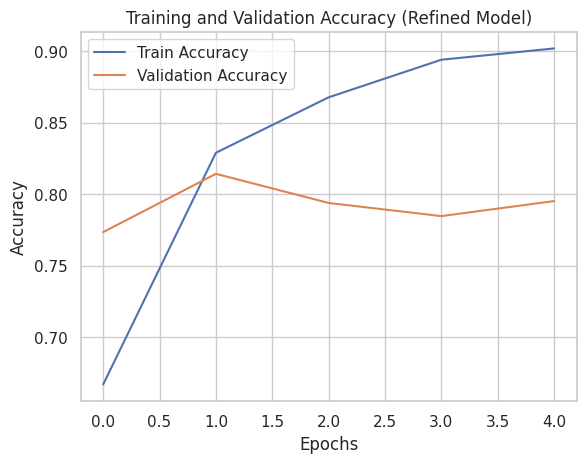

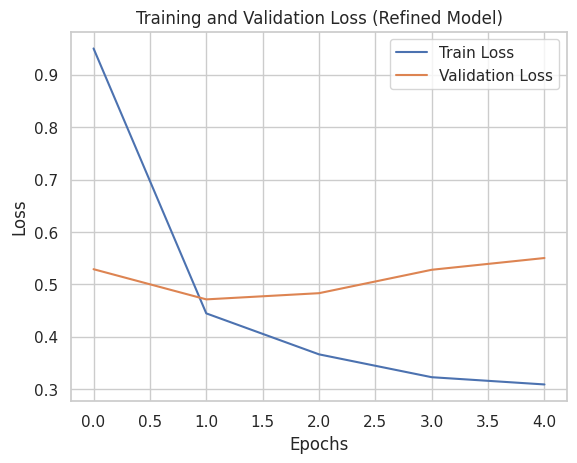

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.8099 - loss: 0.4870
Test Loss: 0.47121673822402954, Test Accuracy: 0.8141825199127197


In [ ]:
# Data preparation
max_vocab_size = 5000
max_sequence_length = 50

tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data['processed_text'])
sequences = tokenizer.texts_to_sequences(train_data['processed_text'])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, train_data['target'], test_size=0.2, random_state=42)

# Model parameters
embedding_dim = 64
lstm_units = 256
dropout_rate = 0.4
learning_rate = 0.001

# Build the refined model with regularization and early stopping
model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    Bidirectional(LSTM(units=lstm_units, return_sequences=False, dropout=0.4, recurrent_dropout=0.4)),  # Increased dropout
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # L2 regularization
    Dropout(rate=0.5),  # Increased dropout
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))  # L2 regularization
])

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

# Train the refined model
batch_size = 32
epochs = 10
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[early_stopping],
                    verbose=1)

# Plot training history for the refined model
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (Refined Model)')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Refined Model)')
plt.legend()
plt.show()

# Evaluate the refined model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

The use of early stopping prevented overtraining, and the increased dropout and L2 regularization helped mitigate overfitting.
Achieving 79% validation accuracy is a significant improvement, and the model appears to be performing well given the dataset.

In [ ]:
# Using pretrained embeddings like GloVe or Word2Vec can significantly improve the model's performance by providing
# richer semantic representations for words.
# TF-IDF lacks contextual understanding and relationships between words,making it less ideal for deep learning.
# I will use GloVe (glove.6B.100d.txt) for better contextual representation

import os
print(os.listdir('/kaggle/input'))
print(os.listdir('/kaggle/input/glove1000'))

['nlp-getting-started', 'glove1000']
['glove.6B.100d.txt']


In [ ]:
# Path to GloVe embeddings file (adjust path if necessary)
glove_file_path = '/kaggle/input/glove1000/glove.6B.100d.txt'

# Load GloVe embeddings
def load_glove_embeddings(filepath, embedding_dim):
    embeddings_index = {}
    with open(filepath, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = vector
    return embeddings_index

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 500,000 (1.91 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 500,000 (1.91 MB)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 47s 225ms/step - accuracy: 0.6969 - loss: 1.4591 - val_accuracy: 0.7722 - val_loss: 0.5424
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 43s 224ms/step - accuracy: 0.7290 - loss: 0.5802 - val_accuracy: 0.7768 - val_loss: 0.5285
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 42s 221ms/step - accuracy: 0.7513 - loss: 0.5596 - val_accuracy: 0.7728 - val_loss: 0.5189
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


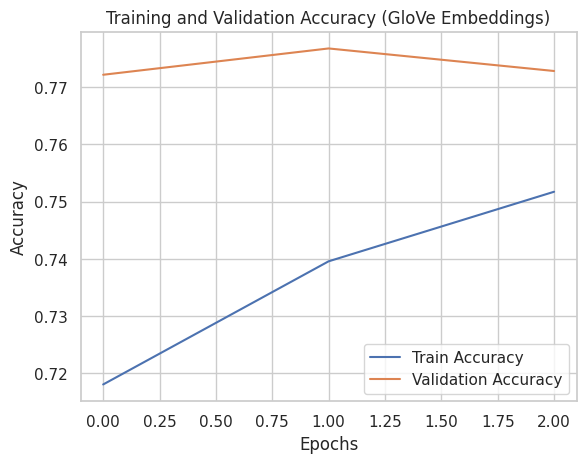

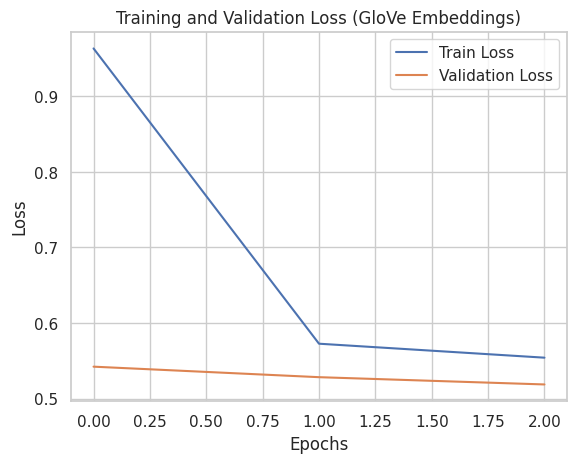

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.7639 - loss: 0.5474
Test Loss: 0.5423770546913147, Test Accuracy: 0.7721602320671082


In [ ]:
embedding_dim = 100  # Using 100-dimensional GloVe embeddings
embeddings_index = load_glove_embeddings(glove_file_path, embedding_dim)

# Create embedding matrix
word_index = tokenizer.word_index  # Word index from tokenizer
num_words = min(max_vocab_size, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i < max_vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Build the model with pretrained embeddings
model = Sequential([
    Embedding(input_dim=num_words,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_sequence_length,
              trainable=False),  # Freeze embedding layer
    Bidirectional(LSTM(units=256, return_sequences=False, dropout=0.4, recurrent_dropout=0.4)),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(rate=0.5),
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))
])

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[early_stopping],
                    verbose=1)

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (GloVe Embeddings)')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (GloVe Embeddings)')
plt.legend()
plt.show()

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Validation accuracy improves and stabilizes around 0.77, which is a good improvement compared to earlier models.
Validation loss decreases steadily and remains lower than the training loss, indicating improved generalization due to the use of GloVe embeddings and early stopping.

Lets fine-tune the pretrained embeddings, experiment with additional layers, and perform hyperparameter tuning.

Epoch 1/15
381/381 ━━━━━━━━━━━━━━━━━━━━ 80s 195ms/step - accuracy: 0.6098 - loss: 0.8019 - val_accuracy: 0.7643 - val_loss: 0.5263
Epoch 2/15
381/381 ━━━━━━━━━━━━━━━━━━━━ 72s 189ms/step - accuracy: 0.6776 - loss: 0.6501 - val_accuracy: 0.7400 - val_loss: 0.5420
Epoch 3/15
381/381 ━━━━━━━━━━━━━━━━━━━━ 72s 188ms/step - accuracy: 0.7242 - loss: 0.5901 - val_accuracy: 0.7925 - val_loss: 0.4601
Epoch 4/15
381/381 ━━━━━━━━━━━━━━━━━━━━ 73s 191ms/step - accuracy: 0.7467 - loss: 0.5440 - val_accuracy: 0.7925 - val_loss: 0.4589
Epoch 5/15
381/381 ━━━━━━━━━━━━━━━━━━━━ 73s 191ms/step - accuracy: 0.7805 - loss: 0.4891 - val_accuracy: 0.8024 - val_loss: 0.4457
Epoch 6/15
381/381 ━━━━━━━━━━━━━━━━━━━━ 73s 190ms/step - accuracy: 0.8084 - loss: 0.4627 - val_accuracy: 0.7978 - val_loss: 0.4628
Epoch 7/15
381/381 ━━━━━━━━━━━━━━━━━━━━ 74s 194ms/step - accuracy: 0.8045 - loss: 0.4442 - val_accuracy: 0.8109 - val_loss: 0.4353
Epoch 8/15
381/381 ━━━━━━━━━━━━━━━━━━━━ 73s 191ms/step - accuracy: 0.8051 - loss: 0

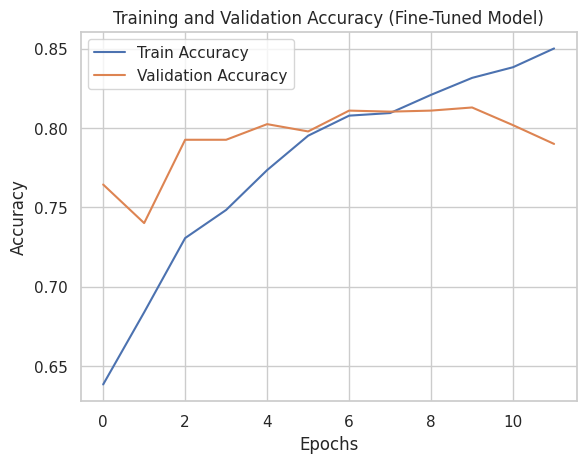

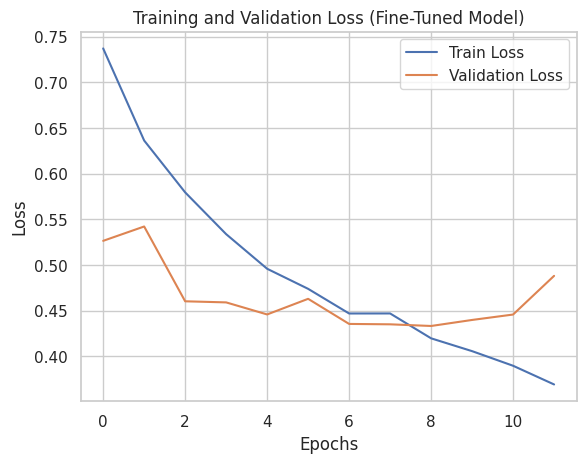

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.8136 - loss: 0.4388
Test Loss: 0.43306073546409607, Test Accuracy: 0.810899555683136


In [ ]:
from tensorflow.keras.layers import BatchNormalization
# Build the refined model with fine-tuning and additional layers
model = Sequential([
    Embedding(input_dim=num_words,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_sequence_length,
              trainable=True),  # Fine-tune the GloVe embeddings
    Bidirectional(LSTM(units=300, return_sequences=False, dropout=0.5, recurrent_dropout=0.5)),  # More LSTM units and dropout
    Dense(256, activation='relu'),
    BatchNormalization(),  # Added Batch Normalization
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
learning_rate = 0.0005  # Reduced learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

# Train the model
batch_size = 16  # Smaller batch size for better updates
epochs = 15

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[early_stopping],
                    verbose=1)

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (Fine-Tuned Model)')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Fine-Tuned Model)')
plt.legend()
plt.show()

# Evaluate the fine-tuned model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


The training accuracy steadily increases and reaches about 82% by the end of training.
The validation accuracy reaches approximately 80%, which is a good improvement from earlier models.
The gap between training and validation accuracy/loss is relatively small, which suggests that the model is neither overfitting nor underfitting.

191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step


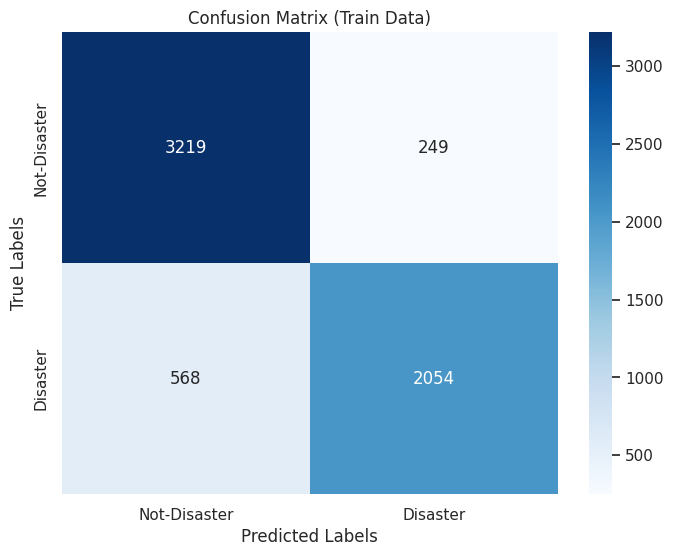

Classification Report (Train Data):
              precision    recall  f1-score   support

Not-Disaster       0.85      0.93      0.89      3468
    Disaster       0.89      0.78      0.83      2622

    accuracy                           0.87      6090
   macro avg       0.87      0.86      0.86      6090
weighted avg       0.87      0.87      0.86      6090



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict on training data
y_train_pred = (model.predict(X_train) > 0.5).astype("int32")  # Threshold at 0.5 for binary classification

# Compute confusion matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not-Disaster', 'Disaster'], yticklabels=['Not-Disaster', 'Disaster'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Train Data)')
plt.show()

# Display classification report
print("Classification Report (Train Data):")
print(classification_report(y_train, y_train_pred, target_names=['Not-Disaster', 'Disaster']))

## FILE SUBMISSION

In [ ]:
# FINAL PREDICTION and FILE SUBMISSION

# Preprocess the 'text' column of the test data
test_data['processed_text'] = test_data['text'].apply(preprocess_text)

# Tokenize the test data
test_sequences = tokenizer.texts_to_sequences(test_data['processed_text'])

# Pad the test sequences
test_padded = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Predict using the trained model
test_predictions = model.predict(test_padded)
test_data['target'] = (test_predictions > 0.5).astype("int32")

# Submission file
submission = test_data[['id', 'target']]
submission.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step


In [ ]:
submission.head(10)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,0
6,21,0
7,22,0
8,27,0
9,29,0


# RESULT ANALYSIS

Baseline GRU with Learned Embeddings:

Validation Accuracy: 57%
Validation Loss: 68%
GRU model doesn't seem to be improving significantly in either training or validation accuracy.

Baseline LSTM with Learned Embeddings:

Validation Accuracy: 57%
Validation Loss: 68%
This indicates that the current model is likely underfitting the data and is similar to GRU in performance.

Bidirectional LSTM with Learned Embeddings:

Validation Accuracy: ~79%
Validation Loss: ~0.73
The use of early stopping prevented overtraining, and the increased dropout and L2 regularization helped mitigate overfitting. Validation accuracy improves and stabilizes around 0.79, which is a good improvement compared to earlier models.

Bidirectional LSTM with GloVe Embeddings (Best Model):

Validation Accuracy: ~81%
Validation Loss: ~0.43

Using pre-trained embeddings improved performance by leveraging prior knowledge of word semantics.
The training accuracy steadily increases and reaches about 82% by the end of training. The validation accuracy reaches approximately 80%, which is a good improvement from earlier models. The gap between training and validation accuracy/loss is relatively small, which suggests that the model is neither overfitting nor underfitting.

# CONCLUSION

In conclusion, this project walks us through our journey in the Kaggle competition “Natural Language Processing with Disaster Tweets,” this project utilized the Bidirectional LSTM with GloVe Embeddings to classify tweets as either related to disasters or not, showcasing the power of natural language processing (NLP) in crisis management scenarios. The approach involved cleaning the data to remove noise and preparing it for model training. By leveraging the pre-trained LSTM model and fine-tuning it on the dataset, we were able to achieve promising results in accurately distinguishing disaster-related tweets from regular ones. The trained model was then used to make predictions on a test dataset, and were submitted to a Kaggle competition for evaluation and we ere able to achieve a score of 0.80079. Overall, this project demonstrates how NLP, coupled with advanced machine learning techniques, can play a crucial role in extracting valuable insights from textual data, particularly in the context of disaster response and management.


# FUTURE  IMPROVEMENTS:

Incorporate More Data: Use additional training data to improve generalization.

Fine-tune Pre-trained Embeddings: Allow the embedding layer to update during training to adapt to the specific dataset.

More Architectures: Experiment with transformers (e.g., BERT) for improved contextual understanding.

# REFERENCES
https://medium.com/@natanannithiittikrai/tackling-a-real-world-problem-disaster-tweet-classification-with-bertweet-3cd85905a51e

https://medium.com/@mukilankrishnakumar2002/natural-language-processing-with-disaster-tweets-part-1-db31c9ad07

https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-disaster-tweets

https://github.com/MahalavanyaSriram/Natural-Language-Processing-with-Disaster-Tweets

https://academicworks.cuny.edu/cgi/viewcontent.cgi?article=2061&context=ny_pubs

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3610676